# Loading Libraries

In [1]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('ERROR') # only show error messages 

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k, 
    get_top_k_items,
    rmse,
    mae,
    rsquared,
    exp_var
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.utils.constants import SEED as DEFAULT_SEED

# System & OS
import sys
import os
import shutil
#import papermill as pm
import pandas as pd

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Datasets

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_ratings_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (357692, 3)
Shape of Test: 	 (89479, 3)


In [4]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3696
Unique Users in Test: 3696
Unique Items in Train: 2769
Unique Items in Test: 2769


# Data Preparation

In [5]:
# Change name of columns 
train = train.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
test = test.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})

In [10]:
# Sort by users 
train = train.sort_values(by='userID')
test = test.sort_values(by='userID')

In [11]:
# Write Dataset to CSV files. This is a pre-step for the NCF Dataset preparation
train_file = "./or_rating_train.csv"
test_file = "./or_rating_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [12]:
# Create the NCF Dataset 
data = NCFDataset(train_file=train_file, test_file=test_file, seed=1, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./or_rating_train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./or_rating_test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./or_rating_test_full.csv ...
100%|██████████| 3696/3696 [01:05<00:00, 56.49it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./or_rating_test_full.csv ...


# Baseline Model

In [13]:
# Initiate Model with pretrained NeuMF
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=50,
    batch_size=50,
    learning_rate=1e-3,
    verbose=10,
    seed=1
)

2023-06-22 14:06:48.511194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 14:06:48.521017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [14]:
# Fit the Modek 
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [32.42s]: train_loss = 0.276681 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [32.54s]: train_loss = 0.274234 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [32.52s]: train_loss = 0.275083 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [32.56s]: train_loss = 0.276756 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [32.47s]: train_loss = 0.278868 


Took 1629.806104875 seconds for training.


In [15]:
# Predict all user and items pairings in Test 
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]

# Create a Datafragme from the Predictions 
predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head()

,userID,itemID,prediction
0,1,1915,0.338273
1,1,3147,0.330756
2,1,892,0.040942
3,1,3352,0.169295
4,1,1291,0.075116


In [16]:
predictions['prediction'] = predictions['prediction'].apply(lambda x: 1 if x > 0.5 else 0)

In [17]:
acc = accuracy_score(test.rating, predictions.prediction)
print(acc)

0.03958470702622962


In [18]:
# Predict ALL User & Item Pairings 
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 47.976190417 seconds for prediction.


In [19]:
# Evaluate Recall & Preicison at 10 
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=10)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=10)

print("Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Precision@K:	0.063582
Recall@K:	0.022287


# Hyperparameter Tuning 

In [20]:
# Initiate Lists for Hyperparameters 
factors = [8, 16, 50]
layers = [[16, 8, 4], [32, 16, 8], [200, 100, 50]]

# Initiate Lists for Assessment
accuracy = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
num_factors = []
layer_shapes = []

for f in factors:
    for l in layers:
        ##### GMF MODEL ##### 
        # Initiate GMF Model
        gmf_model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="GMF",
            n_factors=f,
            layer_sizes=l
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Fit GMF Model: 
        gmf_model.fit(data)
        
        # Save GMF Model:
        gmf_model.save(dir_name='.pretrain/GMF')
        
        ##### MLP MODEL ##### 
        # Initiate MLP Model                 
        mlp_model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="MLP",
            n_factors=f,
            layer_sizes=l
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Fit MLP Model
        mlp_model.fit(data)
        
        # Save MLP Model
        mlp_model.save(dir_name='.pretrain/MLP')
        
        ##### NeuMF Layer #####
        # Initiate NeuMF Model
        model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="NeuMF",
            n_factors=f,
            layer_sizes=l
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Load pretrained Models
        model.load(gmf_dir='.pretrain/GMF', mlp_dir='.pretrain/MLP', alpha=0.5)
        
        # Fit NeuMF Model
        model.fit(data)
        
        
        ##### ACCURACY PREDICTION #####
        # Predict all user and items pairings in Test 
        predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
                    for (_, row) in test.iterrows()]

        # Create a Datafragme from the Predictions 
        predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
        
        # Binarize Output
        predictions['prediction'] = predictions['prediction'].apply(lambda x: 1 if x > 0.5 else 0)
        
        # Binarize Test Ratings
        test_copy = test.copy()
        test_copy['rating'] = test_copy['rating'].apply(lambda x: 1 if x > 0 else 0)
        
        # Predict Accuracy
        acc = accuracy_score(test_copy.rating, predictions.prediction)
        
        # Add Accuracy to list
        accuracy.append(acc)
        
        ##### TOP K PREDICTION
        # Predict All Pairings  
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        # Create Data Frame and Merge
        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
        
        # Recall & Precision at 10 
        eval_precision_10 = precision_at_k(test, all_predictions, col_prediction='prediction', k=10)
        eval_recall_10 = recall_at_k(test, all_predictions, col_prediction='prediction', k=10)
        
        # Recall & Precision at 20
        eval_precision_20 = precision_at_k(test, all_predictions, col_prediction='prediction', k=20)
        eval_recall_20 = recall_at_k(test, all_predictions, col_prediction='prediction', k=20)
        
        
        # Append Lists
        recall_10.append(eval_recall_10)
        recall_20.append(eval_recall_20)
        precision_10.append(eval_precision_10)
        precision_20.append(eval_precision_20)
        num_factors.append(f)
        layer_shapes.append(l)
        
        # Print intermediate Status for Recall@10
        print("Recall@10 for Num Factors: ", f, "Layer Shape: ", l, ":\t", eval_recall_10)
        
        # Print intermediate Status for Recall@20
        print("Recall@20 for Num Factors: ", f, "Layer Shape: ", l, ":\t", eval_recall_20)
        

Recall@10 for Num Factors:  4 Layer Shape:  [16, 8, 4] :	 0.00745454099114729
Recall@20 for Num Factors:  4 Layer Shape:  [16, 8, 4] :	 0.015848866336935608
Recall@10 for Num Factors:  4 Layer Shape:  [32, 16, 8] :	 0.006566671569693035
Recall@20 for Num Factors:  4 Layer Shape:  [32, 16, 8] :	 0.01259211537736731
Recall@10 for Num Factors:  4 Layer Shape:  [200, 100, 50] :	 0.007177778185289641
Recall@20 for Num Factors:  4 Layer Shape:  [200, 100, 50] :	 0.014422645576761027
Recall@10 for Num Factors:  16 Layer Shape:  [16, 8, 4] :	 0.009078826239513194
Recall@20 for Num Factors:  16 Layer Shape:  [16, 8, 4] :	 0.01785928073704738
Recall@10 for Num Factors:  16 Layer Shape:  [32, 16, 8] :	 0.008835782409464487
Recall@20 for Num Factors:  16 Layer Shape:  [32, 16, 8] :	 0.016938567803957884
Recall@10 for Num Factors:  16 Layer Shape:  [200, 100, 50] :	 0.013830789670942234
Recall@20 for Num Factors:  16 Layer Shape:  [200, 100, 50] :	 0.024985742229986334
Recall@10 for Num Factors:  5

In [22]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning = pd.DataFrame({
    "layer size": layer_shapes,
    "factors": num_factors,
    "accuracy": accuracy,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning.sort_values(by='recall@10', ascending=False)

,layer size,factors,accuracy,recall@10,recall@20,precision@10,precision@20
7,"[32, 16, 8]",50,0.105254,0.062169,0.090326,0.152814,0.109646
8,"[200, 100, 50]",50,0.106595,0.061212,0.087111,0.150406,0.107008
6,"[16, 8, 4]",50,0.094089,0.060661,0.085839,0.148295,0.105560
5,"[200, 100, 50]",16,0.063054,0.013831,0.024986,0.037771,0.034443
3,"[16, 8, 4]",16,0.060495,0.009079,0.017859,0.025731,0.025379
4,"[32, 16, 8]",16,0.055700,0.008836,0.016939,0.025298,0.024581
0,"[16, 8, 4]",4,0.012506,0.007455,0.015849,0.020806,0.021577
2,"[200, 100, 50]",4,0.049799,0.007178,0.014423,0.020590,0.020766
1,"[32, 16, 8]",4,0.038624,0.006567,0.012592,0.020779,0.019968


In [23]:
df_tuning.to_csv("or_rating_results.csv")

# Analysis of Hyperparameters

In [24]:
# Impact of Factors
df_tuning.groupby("factors")['recall@10'].mean().sort_values(ascending=False)

factors
50    0.061347
16    0.010582
4     0.007066
Name: recall@10, dtype: float64

In [26]:
# Impact of Layer Size
df_tuning['layer size'] = df_tuning['layer size'].astype(str)

df_tuning.groupby("layer size")['recall@10'].mean().sort_values(ascending=False)

layer size
[200, 100, 50]    0.027407
[32, 16, 8]       0.025857
[16, 8, 4]        0.025731
Name: recall@10, dtype: float64

# Visualizations

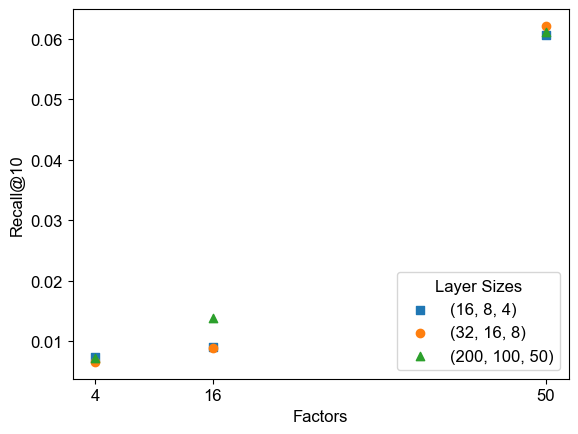

In [25]:
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Define Font Size
plt.rcParams.update({'font.size': 12})

# Create a dictionary to store the plotted points for each category
plotted_points = {}

# Create a scatterplot
fig, ax = plt.subplots()

# Define the shapes for different categories
shapes = ['s', 'o', '^']

# Iterate over each row in the DataFrame
for index, row in df_tuning.iterrows():
    # Get the layer sizes list for the current row
    layer_sizes = row['layer size']
    
    # Convert the layer sizes list to a tuple for dictionary key
    layer_sizes_tuple = tuple(layer_sizes)
    
    # Check if the current category is already in the dictionary
    if layer_sizes_tuple not in plotted_points:
        # Create a new list to store the points for the current category
        plotted_points[layer_sizes_tuple] = []
    
    # Append the points for the current category
    plotted_points[layer_sizes_tuple].append((row['factors'], row['recall@10']))

# Iterate over the plotted points for each category and plot them
for category, points in plotted_points.items():
    factors, recall = zip(*points)
    shape = shapes.pop(0)  # Get the next shape from the list
    ax.scatter(factors, recall, marker=shape, label=str(category))

# Set the labels for x and y axes
ax.set_xlabel('Factors')
ax.set_ylabel('Recall@10')

# Set the x-axis ticks to the desired values
ax.set_xticks([4, 16, 50])

# Add a legend with the label "Layer Sizes" above the points
legend = ax.legend(title='Layer Sizes', loc='lower right')
legend.get_title().set_fontsize('12')  # Set the font size of the legend title

# Show the scatterplot
plt.show()


Text(0, 0.5, 'Accuracy on Test Set')

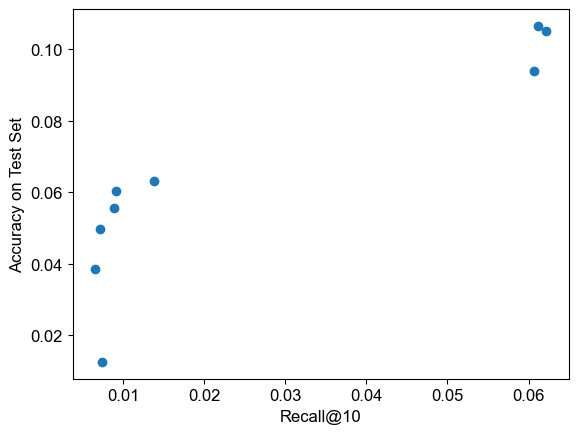

In [27]:
#plt.figure(figsize=(7,5))
plt.scatter(df_tuning['recall@10'], df_tuning['accuracy'])
plt.xlabel('Recall@10')
plt.ylabel('Accuracy on Test Set')

# Calculation Accuracy

In [ ]:
gmf_model = NCF(
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="GMF",
    n_factors=50,
    n_epochs=50,
    batch_size=50,
    learning_rate=0.005,
    seed=1,
    verbose=False
)

# Fit GMF Model: 
gmf_model.fit(data)

# Save GMF Model:
gmf_model.save(dir_name='.pretrain/GMF')

##### MLP MODEL ##### 
# Initiate MLP Model                 
mlp_model = NCF(
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="MLP",
    n_factors=50,
    n_epochs=50,
    batch_size=50,
    learning_rate=0.005,
    seed=1,
    verbose=False
)

# Fit MLP Model
mlp_model.fit(data)

# Save MLP Model
mlp_model.save(dir_name='.pretrain/MLP')

##### NeuMF Layer #####
# Initiate NeuMF Model
model = NCF(
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=50,
    n_epochs=50,
    batch_size=50,
    learning_rate=0.005,
    seed=1,
    verbose=False
)

# Load pretrained Models
model.load(gmf_dir='.pretrain/GMF', mlp_dir='.pretrain/MLP', alpha=0.5)

# Fit NeuMF Model
model.fit(data)


##### ACCURACY PREDICTION #####
# Predict all user and items pairings in Test 
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
            for (_, row) in test.iterrows()]

# Create a Datafragme from the Predictions 
predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

# Binarize Output
predictions['prediction'] = predictions['prediction'].apply(lambda x: 1 if x > 0.5 else 0)

# Predict Accuracy
acc = accuracy_score(test.rating, predictions.prediction)